# TS6: Estimación espectral a prueba: Ancho de banda del Electrocardiograma. 
# Aplicando Filtros al ECG

En esta tarea realizaremos el punto 4 del TP4

4) En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:


**.Ruido causado por el movimiento de los electrodos (Alta frecuencia)**

**.Ruido muscular (Alta frecuencia)**

**.Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)**

Ayuda: Los latidos presentes en el registro de ECG, alineados y clasificados (de origen normal y ventricular) poseen las siguientes características temporales y frecuenciales:

## Diseño de filtros IIR y FIR

Filtraremos la señal de ECG con un **Pasa Banda** para asegurar una atenuacion de 40dB en las frecuencias de corte con bajo ripple

Se aplica filtfilt para que cumpla: 

$$|H|.e^{jw} . |H|.e^{-jw} = |H|^2$$

la segunda vez lo aplica con la fase invertida para que la fase final sea nula
Como se aplica el filtro dos veces, cada etapa la diseñamos con una transferencia de $$|H|/2$$ 

### Plantilla:

$$fs_1 = 0.25Hz$$

$$fp_1 = 0.75Hz$$

$$fp_2 = 30Hz$$

$$fs_2 = 50Hz$$

### Filtro IIR

Filtro Chebysheev tipo 2:

    .asegura plana la banda de paso
    .ripple en las bandas donde no tiene importancia su distorsión.

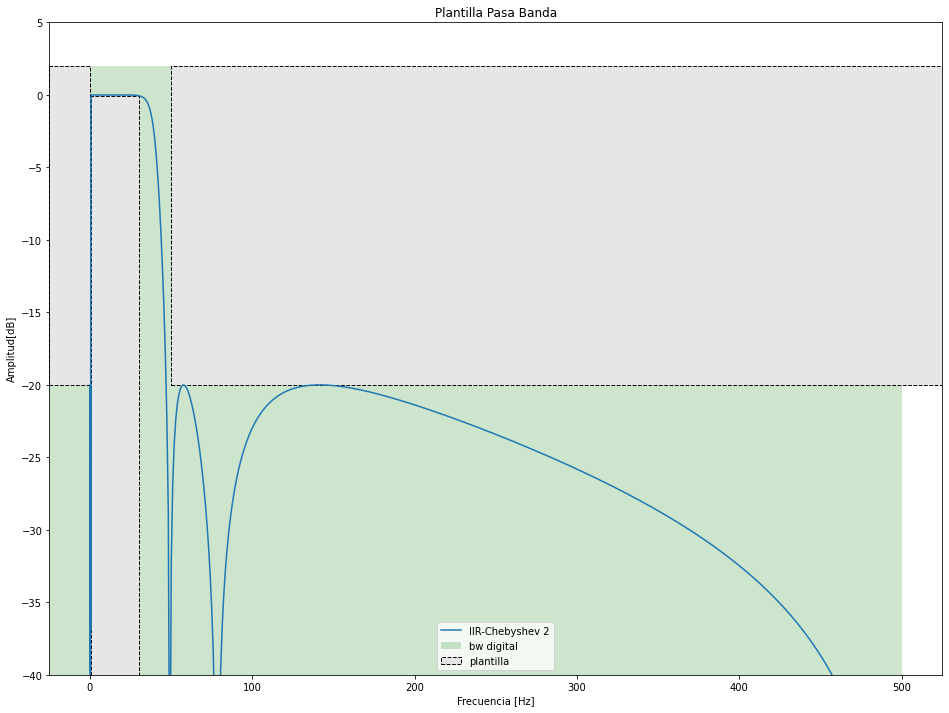

In [1]:
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
from splane import plot_plantilla
import scipy.io as sio

#plt.style.use('dark_background')

mat_struct = sio.loadmat('ECG_TP4.mat')
ecg_one_lead = mat_struct['ecg_lead']

fs = 1000 # Hz
nyq_frec = fs / 2

# Como utilizaremos FiltFilt,el ripple y la atenuacion final seran el doble de la especificada
ripple = 0.05 # dB
alfa_min = 20 # dB

ws1 = 0.25 #Hz
wp1 = 0.75 #Hz
wp2 = 30 #Hz
ws2 = 50 #Hz

len_zeros = int(10e3)

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec

bp_sos_iir = sig.iirdesign([wp1, wp2], [ws1, ws2], ripple, alfa_min, analog=False,ftype= 'cheby2', output='sos', fs=fs)

w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
w = w_rad / np.pi * nyq_frec

_,h_filter = sig.sosfreqz(bp_sos_iir,worN=w_rad)

# cumplimos con la plantilla
plt.gcf().set_size_inches(16, 12)
plt.title("Plantilla Pasa Banda")
plt.plot(w, 20 * np.log10(abs(h_filter)), label='IIR-Chebyshev 2')
plt.ylim([-40,2])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud[dB]")
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = alfa_min, fs = fs)

Podemos ver que cumplimos con la plantilla de diseño. Ahora aplicamos este filtro a la señal de ECG

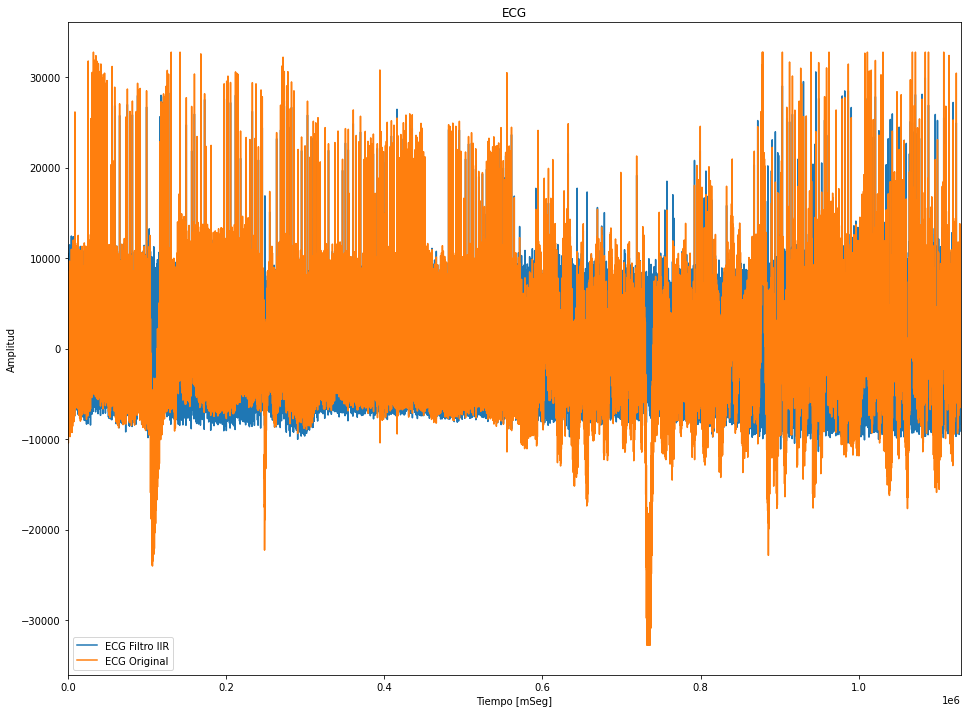

In [2]:
ECG_f_IIR = sig.sosfiltfilt(bp_sos_iir, ecg_one_lead, axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ECG_f_IIR, label = "ECG Filtro IIR")
plt.plot(ecg_one_lead, label = "ECG Original")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

La señal de ECG queda plana, sin ruido de baja y alta frecuencia

### Filtro FIR
$$fs_1 = 0.25Hz$$

$$fp_1 = 0.75Hz$$

$$fp_2 = 30Hz$$

$$fs_2 = 50Hz$$

Para formar el **Pasa Banda** voy a utilizar un **Pasa Alto** y un **Pasa Bajo** en cascada:

Por un lado, diseño la parte **Pasa Alto** con una mayor cantidad de coeficientes ya que la transición es muy exigente. Para la frecuencia de corte inferior en $fs_1 = 0.25Hz$ y la frecuencia de paso superior en $fp_1 = 0.75Hz$

Luego diseñaremos un filtro **Pasa Bajo** con una menor cantidad de coeficientes ya que la transición no es tan exigente. Este tendra una $fp_2 = 30Hz$ y una $fs_2 = 50Hz$

Finalmente haremos una convolución de ambos (sus numeradores), obteniendo asi el filtro **Pasa Banda** deseado

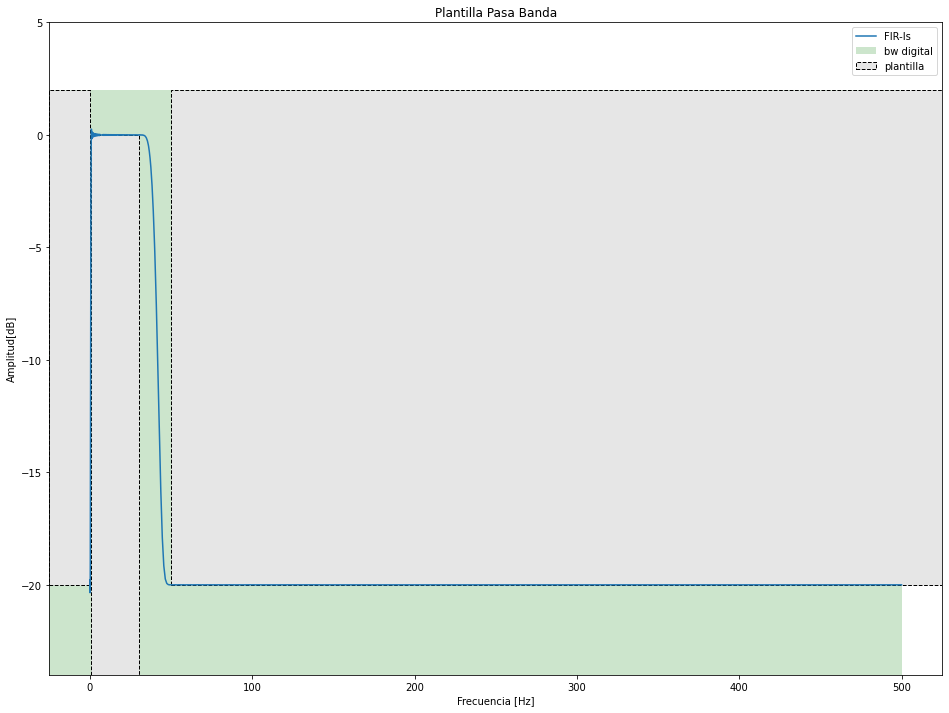

In [3]:
# Utilizo el filtro FIR del tipo cuadrados minimos

ripple = 0 # dB
atenuacion = 20 # dB

fs_n = fs/nyq_frec

# vector de frecuencias necesarias para el diseño
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec

# ganancias deseadas
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion]) # dB
gains = 10**(gains/20) # Veces

# diseño pasa alto
ls_bands_hp = np.append(frecs[:3],[1.0])
ls_desired_hp = np.append(gains[:3],[1.0])
ls_weight_hp = np.array([20, 1])

cant_coef = 3000    # Esta parte es mas exigente, por eso requiero mas coeficientes
if cant_coef % 2 == 0:
    cant_coef += 1
    

num_firls_hp = sig.firls(cant_coef, ls_bands_hp, ls_desired_hp, weight = ls_weight_hp, fs=fs_n)

# diseño pasa bajo
ls_band_lp = np.append([0.0],frecs[3:])
ls_desired_lp = np.append([1.0],gains[3:])
ls_weight_lp = np.array([5, 10])
cant_coef = 500 # Menor exigencia, menor cantidad de coeficientes

if cant_coef % 2 == 0:
    cant_coef += 1

num_firls_lp = sig.firls(cant_coef, ls_band_lp, ls_desired_lp, weight = ls_weight_lp, fs=fs_n)

# diseño pasa banda : Union de pasa alto y pasa bajo
w_rad  = np.append(np.logspace(-2, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_rad  = np.append(w_rad, np.linspace(40, nyq_frec, 500, endpoint=True) ) / nyq_frec * np.pi
w = w_rad / np.pi * nyq_frec

num_firls_bp = np.convolve(num_firls_lp, num_firls_hp)
den_fir = 1.0

_, h_firls_bp = sig.freqz(num_firls_bp, den_fir,w_rad)

# cumplimos con la plantilla
plt.gcf().set_size_inches(16, 12)
plt.title("Plantilla Pasa Banda")
plt.plot(w, 20 * np.log10(abs(h_firls_bp)), label='FIR-ls')
plt.ylim([-24,2])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Amplitud[dB]")
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)


Una vez que cumple la plantilla de diseño, hacemos pasar el ECG por el filtfilt

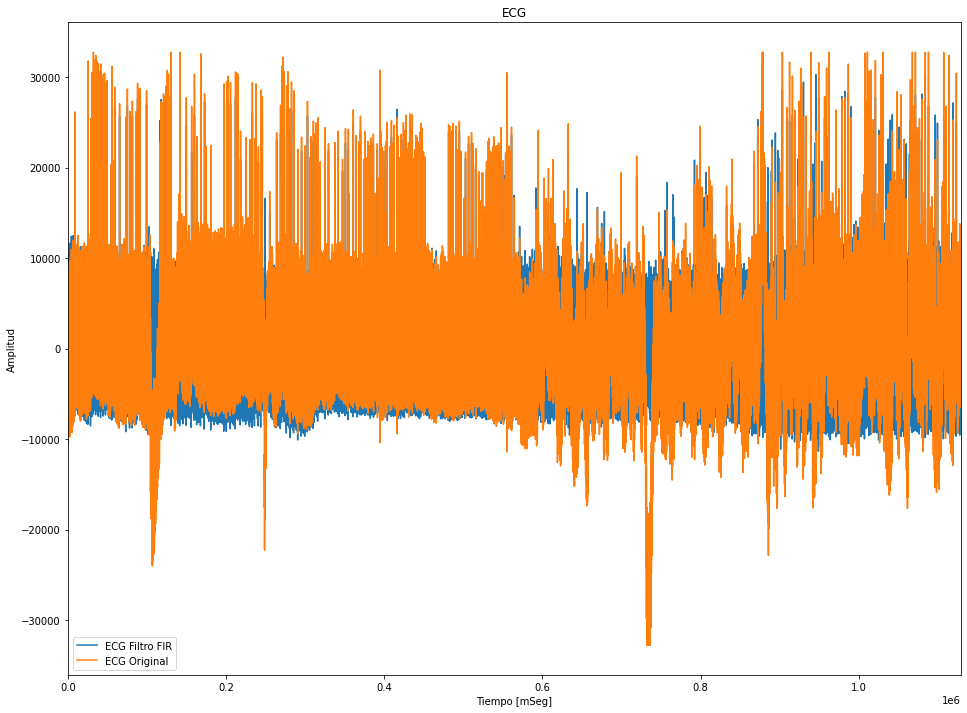

In [4]:
ECG_f_FIR = sig.filtfilt(num_firls_bp, den_fir, ecg_one_lead,axis = 0)
plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ECG_f_FIR, label = "ECG Filtro FIR")
plt.plot(ecg_one_lead, label = "ECG Original")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

Al igual que con el filtro FIR, la señal se ve desafectada por las interferencias de baja y alta frecuencia

### Comparación de ambos filtros

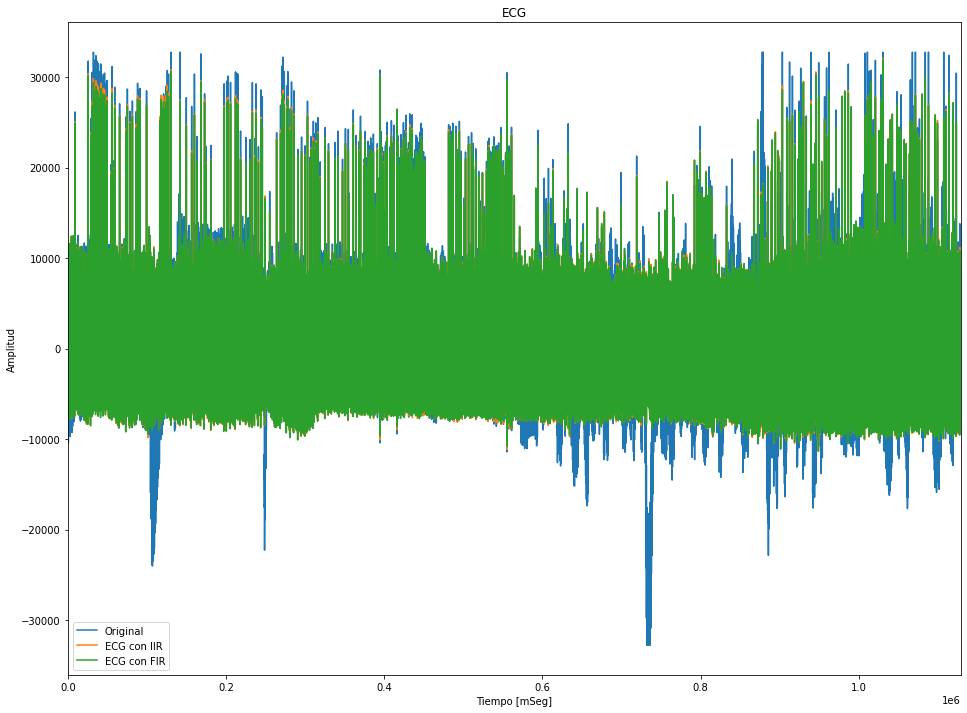

In [5]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "ECG con IIR")
plt.plot(ECG_f_FIR, label = "ECG con FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

Ambas señales se encuentran sobre el nivel base, ahora podemos analizar la señal ECG sin interferencias por parte de la medicion del operario:

NOTA no se considera cambio de bioimpedancia al medir ECG  

### Caso Reposo

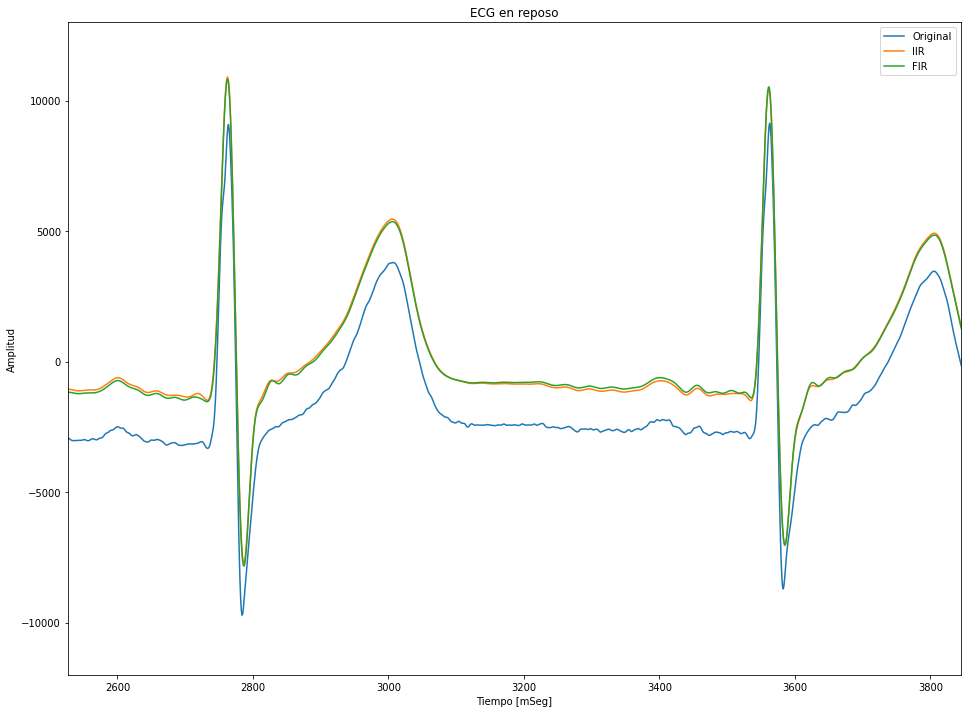

In [6]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en reposo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([2527,3845])
plt.ylim([-12000,13000])
plt.legend()

En reposo, es de notarse que se elimina el nivel de offset de la señal original. 
Como es una señal de baja frecuencia, no se aprecian las interferencias externas.

Sin embargo veremos algunos casos interesantes que se logra con los filtros

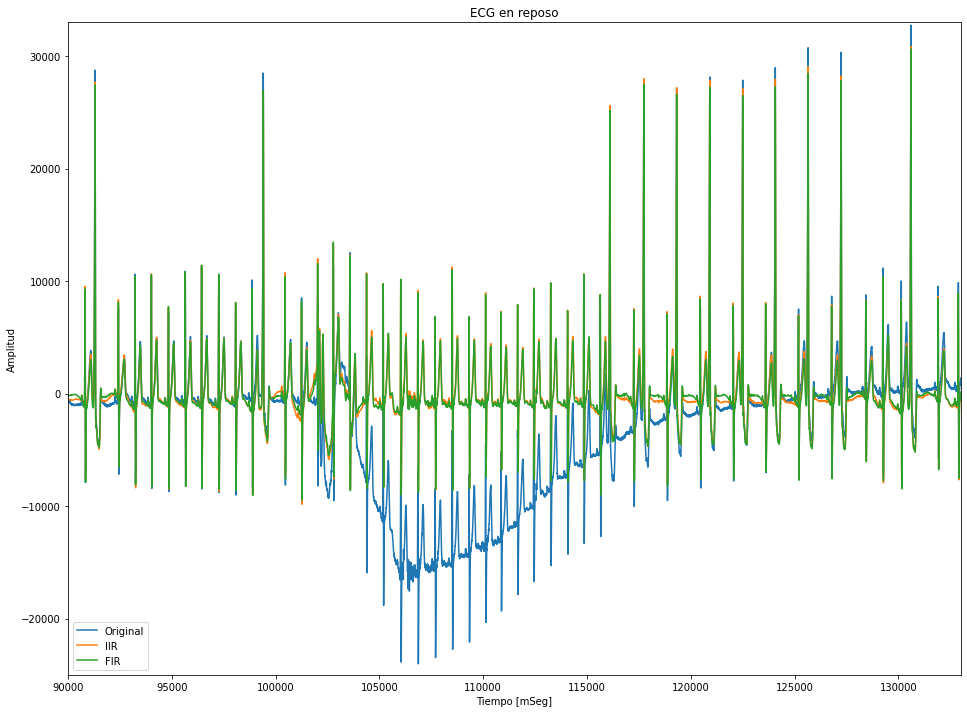

In [7]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en reposo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([90000,133000])
plt.ylim([-25000,33000])
plt.legend()

Antes de entrar al estado de Movimiento/Ejercicio, se ve que la desviacion de la señal que tiene la señal original se corrige, quedando el ECG sobre la linea horizontal

### Caso Ejercicio

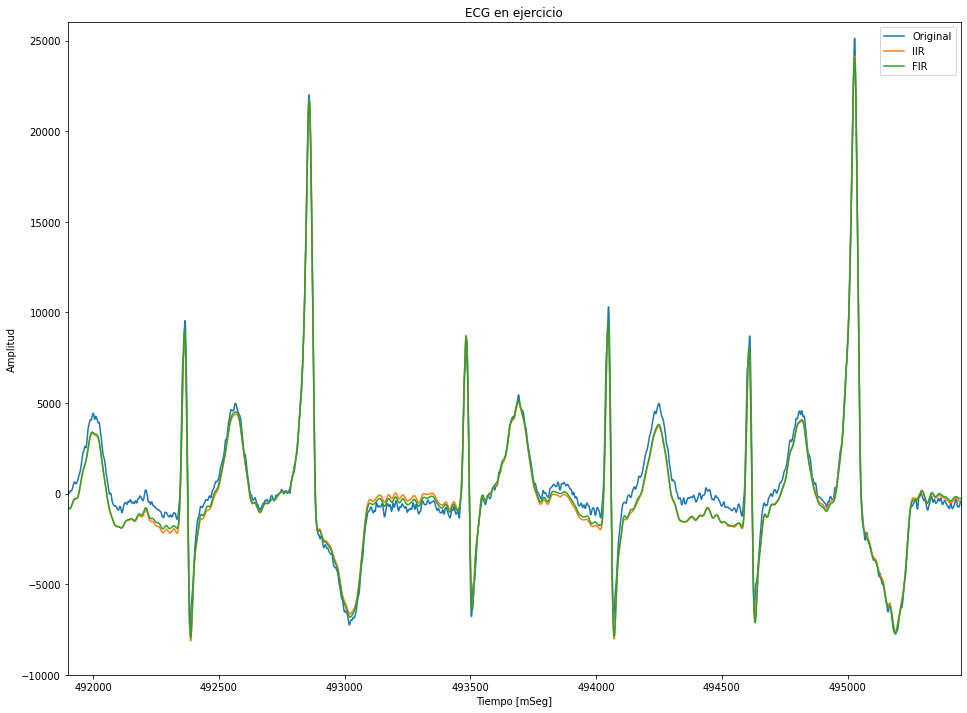

In [8]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en ejercicio")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([491900,495450])
plt.ylim([-10000,26000])
plt.legend()


En estado de Movimiento/Ejercicio, el ECG mantiene su forma
No hay interferencia de alta frecuencia

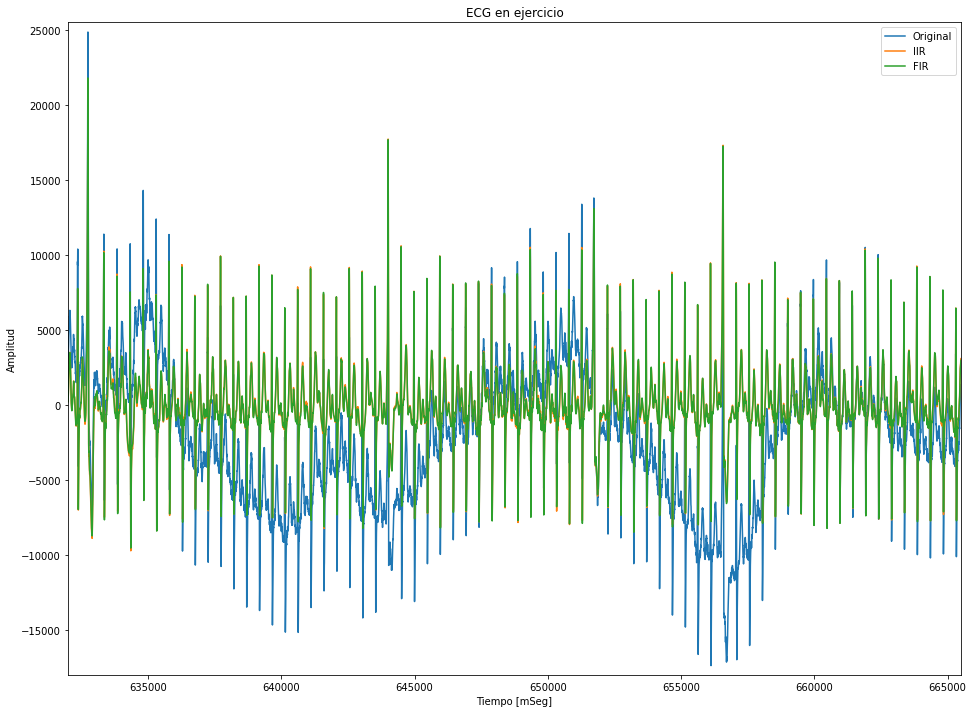

In [9]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG en ejercicio")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([632000,665500])
plt.ylim([-18000,25500])
plt.legend()

### Caso pico de Esfuerzo

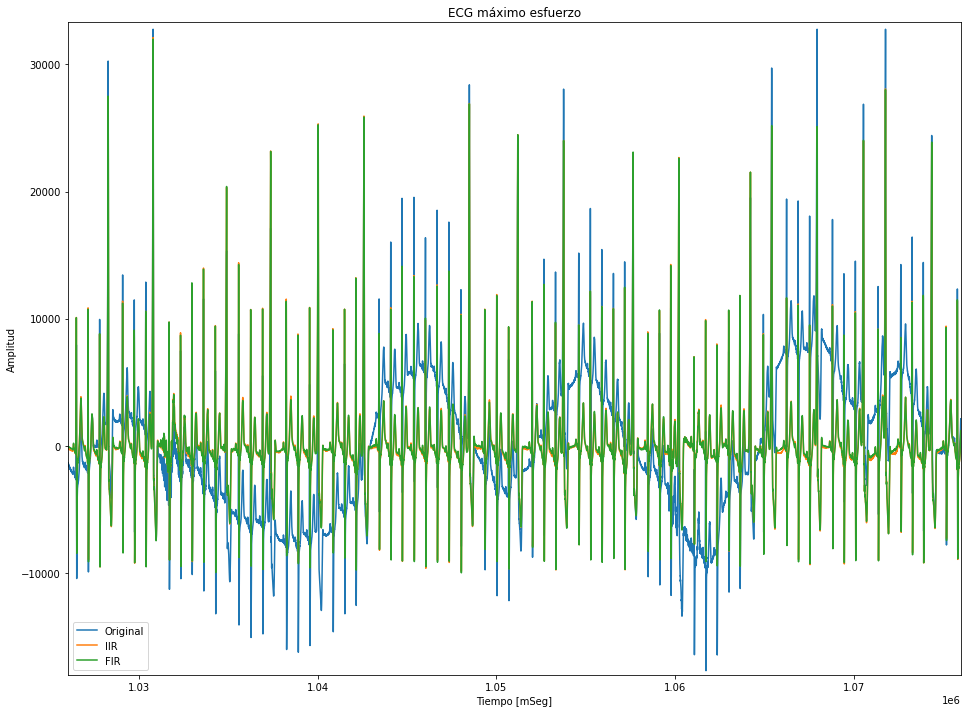

In [10]:
plt.gcf().set_size_inches(16, 12)
plt.title("ECG máximo esfuerzo")
plt.plot(ecg_one_lead, label = "Original")
plt.plot(ECG_f_IIR, label = "IIR")
plt.plot(ECG_f_FIR, label = "FIR")
plt.xlabel("Tiempo [mSeg]")
plt.ylabel("Amplitud")
plt.xlim([1026000,1076000])
plt.ylim([-18000,33300])
plt.legend()

# Analisis de la Densidad Espectral de Potencia

Aplicamos ambos filtros y vemos la respueta, ya vimos que no pierde informacion la señal de ECG al atravesarlos

## Caso IIR

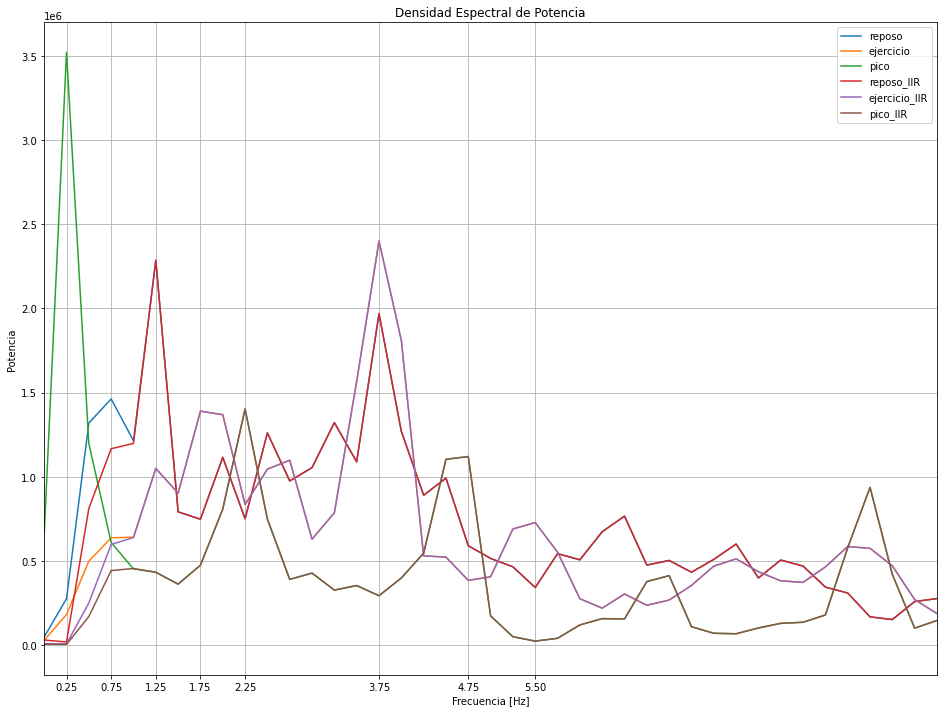

In [11]:
fs = 1000
n = [100, 300, 760, 1000, 4000]

# Estado Reposo: Analizando la señal de ECG podemos notar que el paciente en esta seccion estuvo en reposo:
ECG_reposo = (ecg_one_lead[0:100000])
[f, PXX_pot_reposo] = sig.welch(ECG_reposo, fs = fs,nperseg = n[4], axis = 0)

# Estado Movimiento/Ejercicio: En esta sección los latido van reduciendo su período 
ECG_reposo_ejercicio = (ecg_one_lead[450000:550000])
[f, PXX_pot_ejercicio] = sig.welch(ECG_reposo_ejercicio, fs = fs,nperseg = n[4], axis = 0)

# Picos: Los latidos son mas rapidos
ECG_peak = (ecg_one_lead[750000:850000])
[f, PXX_pot_peak] = sig.welch(ECG_peak, fs = fs,nperseg = n[4], axis = 0)

## FILTRO IIR APLICADO ##
ECG_IIR_reposo = (ECG_f_IIR[0:100000])
[f, PXX_IIR_reposo] = sig.welch(ECG_IIR_reposo, fs = fs,nperseg = n[4], axis = 0)

ECG_IIR_ejercicio = (ECG_f_IIR[450000:550000])
[f, PXX_IIR_ejercicio] = sig.welch(ECG_IIR_ejercicio, fs = fs,nperseg = n[4], axis = 0)


ECG_IIR_peak = (ECG_f_IIR[750000:850000])
[f, PXX_IIR_peak] = sig.welch(ECG_IIR_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'pico')
plt.plot(f, (PXX_IIR_reposo), label = 'reposo_IIR')
plt.plot(f, (PXX_IIR_ejercicio), label = 'ejercicio_IIR')
plt.plot(f, (PXX_IIR_peak), label = 'pico_IIR')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

Podemos notar que practicamente eliminamos la interferencia que se producia en $f = 0,25Hz$. 

### Potencia en dB


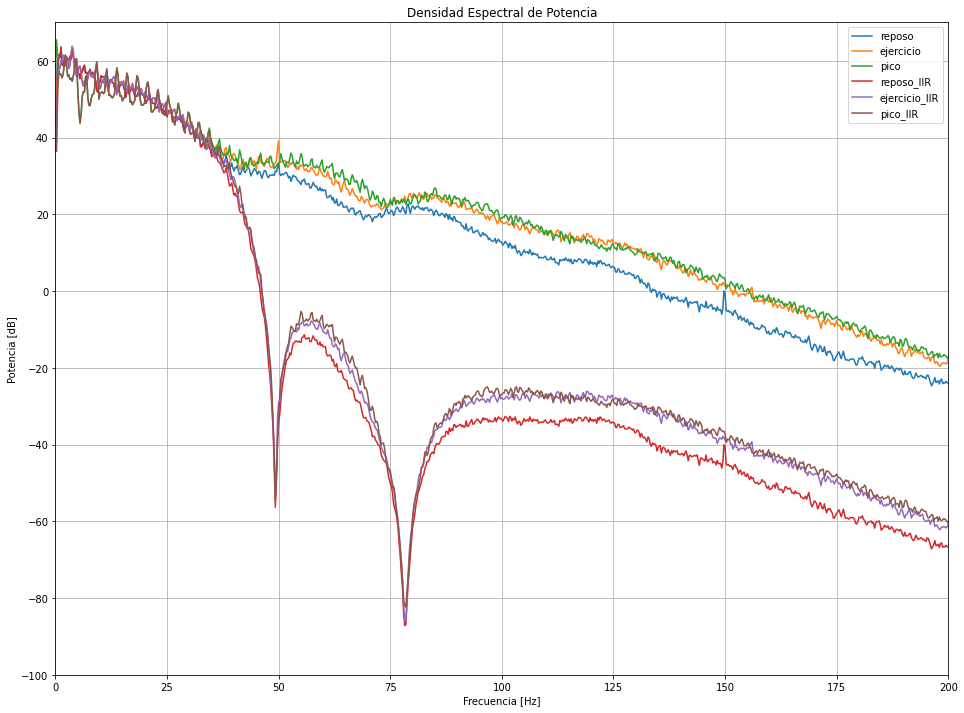

In [12]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.plot(f, 10*np.log10(PXX_IIR_reposo), label = 'reposo_IIR')
plt.plot(f, 10*np.log10(PXX_IIR_ejercicio), label = 'ejercicio_IIR')
plt.plot(f, 10*np.log10(PXX_IIR_peak), label = 'pico_IIR')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
plt.xlim([0,200])
plt.ylim([-100,70])
plt.grid()
plt.legend()

A partir de $f = 30Hz$ la señal que pasa por el filtro, comienza a atenuarse hasta llegar a $(-60dB ; 50Hz)$

Luego, cerca de 75Hz tambien hay un pico descendente, que sobrepasa -80dB 

Genera un efecto similar a un filtro Notch

Ventajas:

-IIR tiene mayor atenuacion en fpaso2 que un FIR (analisis en proxima seccion)

Desventaja:

-fase no lineal

## Caso FIR

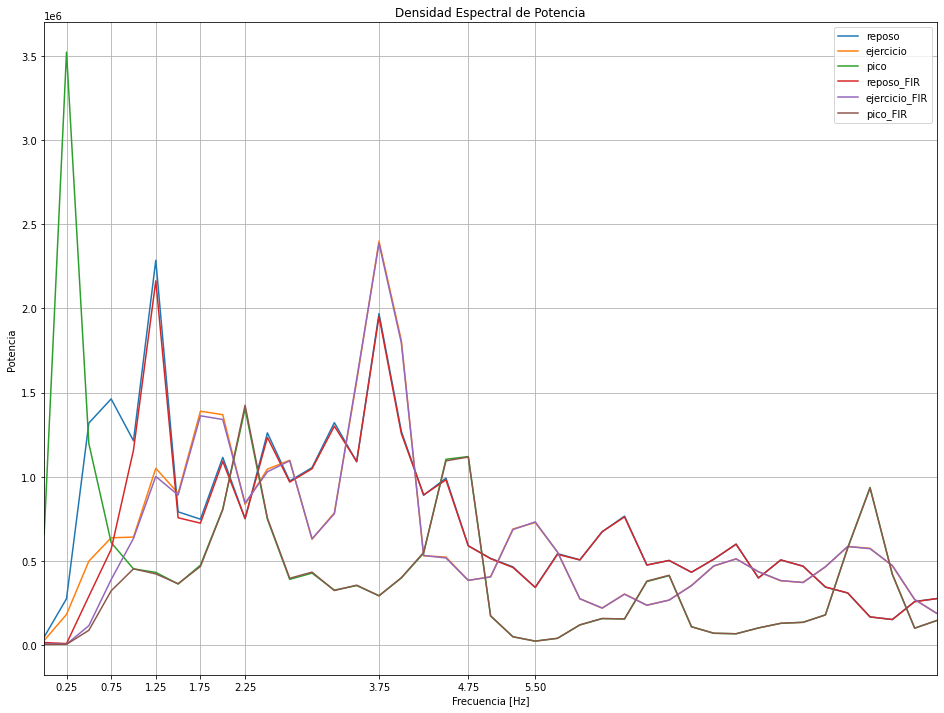

In [13]:
## FILTRO FIR APLICADO
ECG_FIR_reposo = (ECG_f_FIR[0:100000])
[f, PXX_FIR_reposo] = sig.welch(ECG_FIR_reposo, fs = fs,nperseg = n[4], axis = 0)

ECG_FIR_ejercicio = (ECG_f_FIR[450000:550000])
[f, PXX_FIR_ejercicio] = sig.welch(ECG_FIR_ejercicio, fs = fs,nperseg = n[4], axis = 0)

ECG_FIR_peak = (ECG_f_FIR[750000:850000])
[f, PXX_FIR_peak] = sig.welch(ECG_FIR_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'pico')
plt.plot(f, (PXX_FIR_reposo), label = 'reposo_FIR')
plt.plot(f, (PXX_FIR_ejercicio), label = 'ejercicio_FIR')
plt.plot(f, (PXX_FIR_peak), label = 'pico_FIR')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

En este caso tambien eliminamos correctamente la interferencia producida en $f = 0,25Hz$, aunque existe una pequeña variación con respecto a las señales originales en las frecuencias iniciales, produciendose la mayor variacion en el caso de reposo

Ventaja:

-Fase lineal

-Eliminamos correctamente la interferencia producida en $f = 0,25Hz$

Desventaja:

-Distorsion en baja frecuencia

### Potencia en dB


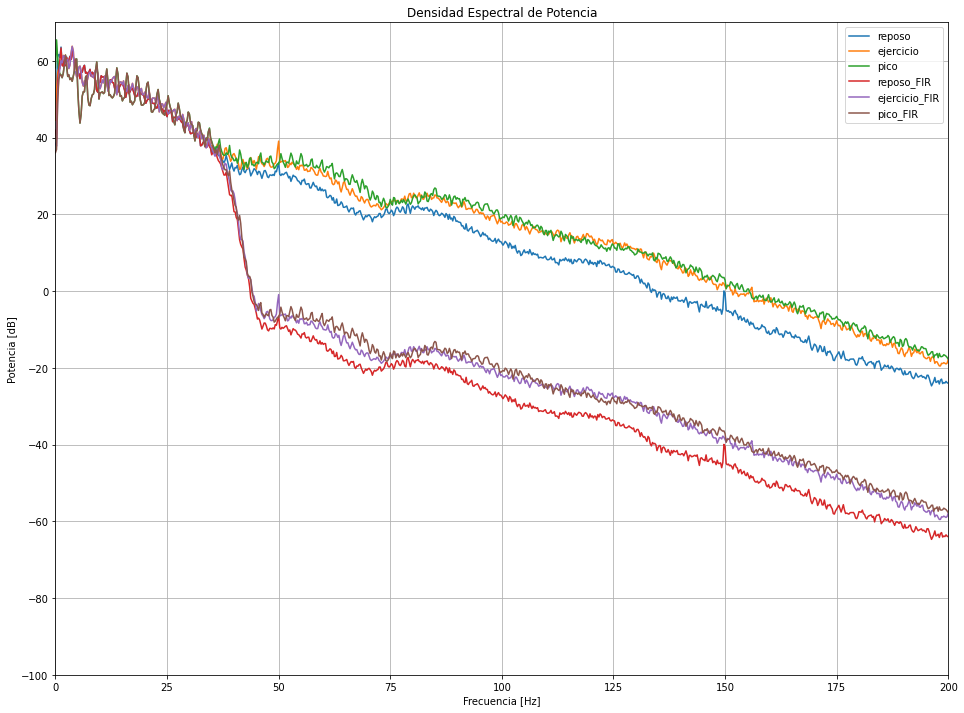

In [14]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.plot(f, 10*np.log10(PXX_FIR_reposo), label = 'reposo_FIR')
plt.plot(f, 10*np.log10(PXX_FIR_ejercicio), label = 'ejercicio_FIR')
plt.plot(f, 10*np.log10(PXX_FIR_peak), label = 'pico_FIR')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
plt.xlim([0,200])
plt.ylim([-100,70])
plt.grid()
plt.legend()

Notamos que $f = 30Hz$ la señal filtrada comienza a atenuarse, y a partir de $f = 50Hz$ tenemos una atenuación constante de 40dB, respetando lo visto en la plantilla de diseño

Conclusion: 

Se comparo la respuesta de un filtro FIR y un filtro IIR, al aplicar una señal de ECG
Para proseguir se podria realizar una implementacion sobre FPGA/Modulo DSP con los coeficientes y generar bloques de multiplicaciones/divisiones